# Goal

* Understand the data
* Reproduce important published inferences

## Resources (as of 27.12.2020):

* https://www.bpb.de/nachschlagen/zahlen-und-fakten/soziale-situation-in-deutschland/61538/altersgruppen
* https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/Dez_2020/2020-12-22-de.pdf?__blob=publicationFile
* https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Altersverteilung.html
* https://edoc.rki.de/bitstream/handle/176904/7603/2020-12-22_12-15_DIVI_Intensivregister_Report.pdf?sequence=1&isAllowed=y
* https://www.tagesschau.de/faktenfinder/dunkelziffer-corona-neuinfektionen-101.html
* https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/nCoV.html
* https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Klinische_Aspekte.html;jsessionid=3A8AE18D9331A3E402DB43E6ADF837EE.internet051?nn=2386228

In [811]:
import calendar
import datetime
import glob
import re

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pdf2image import convert_from_path
from PIL import Image
from pytesseract import image_to_string
import requests
import seaborn as sb

In [915]:
# TODO: Download / extract data automatically

demography = pd.read_excel("corona.xlsx")
deaths = pd.read_excel("corona.xlsx", sheet_name=1)
incidences = pd.read_excel("corona.xlsx", sheet_name=2)

In [865]:
demography.columns = ["-", "0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-84", "85+"]
demography["80+"] = demography[["80-84", "85+"]].sum(axis=1)
demography.drop(["80-84", "85+", "-"], axis=1, inplace=True)
universal_col = demography.columns
demography = demography*1000
demography["type"] = "age"
demography.head()

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+,type
0,7589000,7706000,9801000,10646000,10426000,13474000,10302000,7686000,5390000,age


In [866]:
deaths.columns = ["Geschlecht", "0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89", "90+"]
deaths.drop("Geschlecht", axis=1, inplace=True)
deaths = deaths.apply(lambda x: sum(x), axis=0).to_frame().transpose()
deaths["80+"] = deaths[["80-89", "90+"]].sum(axis=1)
deaths.drop(["80-89", "90+"], axis=1, inplace=True)
deaths["type"] = "deaths"
deaths.head()

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+,type
0,12,5,28,64,197,761,2157,5468,18272,deaths


In [867]:
incidences["total"] = incidences.loc[:, [i for i in range(10, 52)]].sum(axis=1).tolist()
incidences = incidences[["Altersgruppe", "total"]].transpose()
incidences.columns = incidences.iloc[0].values
interm_cols = [col.replace(" ", "") for col in incidences.columns]
incidences.columns = interm_cols
incidences.drop(["Altersgruppe"], inplace=True)

In [868]:
incidences["80+"] = incidences[["90+", "85-89", "80-84"]].sum(axis=1)
incidences["0-9"] = incidences[["0-4", "5-9"]].sum(axis=1)
for i in range(1, 8):
    incidences[f"{i}0-{i}9"] = incidences[[f"{i}0-{i}4", f"{i}5-{i}9"]].sum(axis=1)
incidences.drop(interm_cols, axis=1, inplace=True)
incidences["type"] = "incidences"

In [869]:
incidences.head()

,80+,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,type
total,129044.0,67685.0,144684.0,251667.0,229802.0,218590.0,253490.0,135417.0,83419.0,incidences


In [871]:
total = pd.concat([demography, deaths, incidences], axis=0).reset_index(drop=True).transpose()
total.columns = total.loc["type"].tolist()
total.drop("type", axis=0, inplace=True)
total['ratio_dd'] = total['deaths'] / total['age']
total['ratio_id'] = total['incidences'] / total['age']
total['ratio_di'] = total['deaths'] / total['incidences']
bins = [i for i in range(0, 90, 10)]
for col in total.columns:
    total[col] = pd.to_numeric(total[col], downcast="float")
total

,age,deaths,incidences,ratio_dd,ratio_id,ratio_di
0-9,7589000.0,12.0,67685.0,1.581236e-06,0.008919,0.000177
10-19,7706000.0,5.0,144684.0,6.488451e-07,0.018776,0.000035
20-29,9801000.0,28.0,251667.0,2.856851e-06,0.025678,0.000111
30-39,10646000.0,64.0,229802.0,6.011648e-06,0.021586,0.000279
40-49,10426000.0,197.0,218590.0,1.889507e-05,0.020966,0.000901
50-59,13474000.0,761.0,253490.0,5.647914e-05,0.018813,0.003002
60-69,10302000.0,2157.0,135417.0,2.093768e-04,0.013145,0.015929
70-79,7686000.0,5468.0,83419.0,7.114233e-04,0.010853,0.065549
80+,5390000.0,18272.0,129044.0,3.389981e-03,0.023941,0.141595


# Understand the data

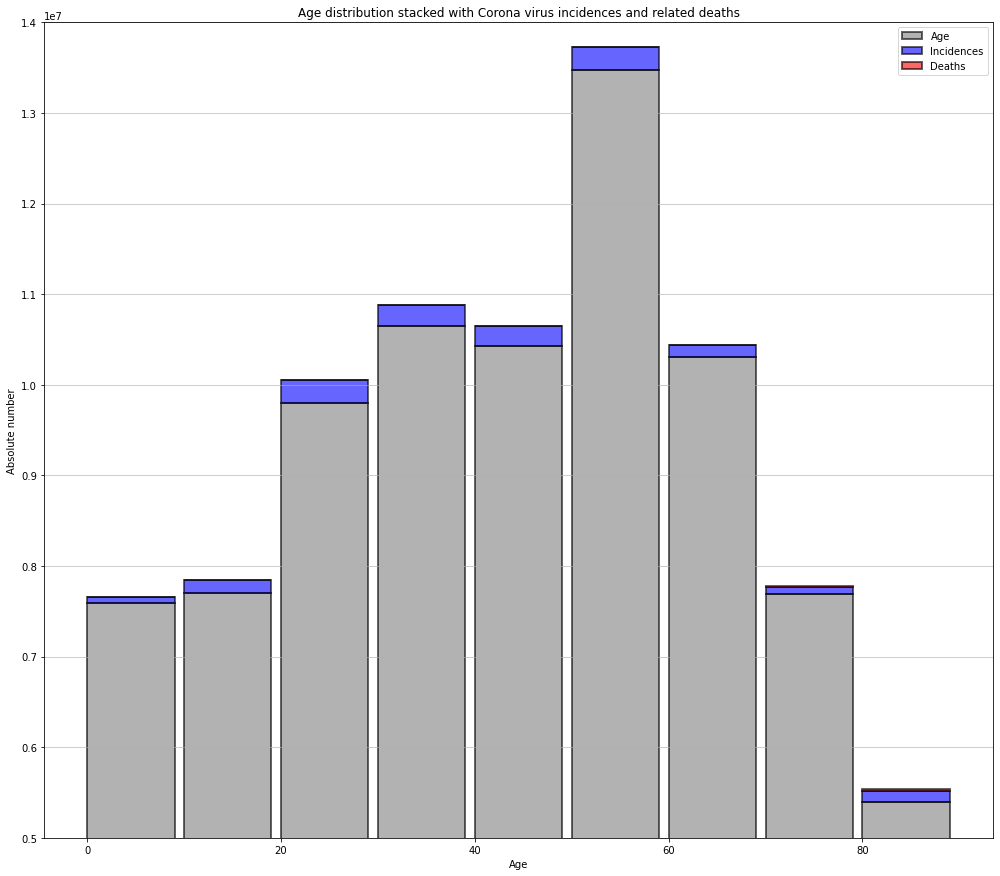

In [874]:
# TODO: Add or refer to particular terminology within the notebook

plt.subplots(figsize=(17, 15))
plt.grid(axis='y', alpha=0.75)

b1 = plt.bar(bins, total["age"], align='edge', width=9,
       alpha=0.6, color="gray", edgecolor="black", linewidth=2)

b2 = plt.bar(bins, total["incidences"], align='edge', width=9, alpha=0.6, 
        color="blue", edgecolor="black", linewidth=2, bottom=total["age"])

b3 = plt.bar(bins, total["deaths"], align='edge', width=9, alpha=0.6, 
        color="red",edgecolor="black", linewidth=2, bottom=total["age"]+total['incidences'])

plt.xlabel("Age")
plt.ylabel("Absolute number")
plt.title("Age distribution stacked with Corona virus incidences and related deaths")
plt.legend((b1[0], b2[0], b3[0]), ('Age', 'Incidences', 'Deaths'))
plt.ylim([5000000, 14000000])
plt.show()

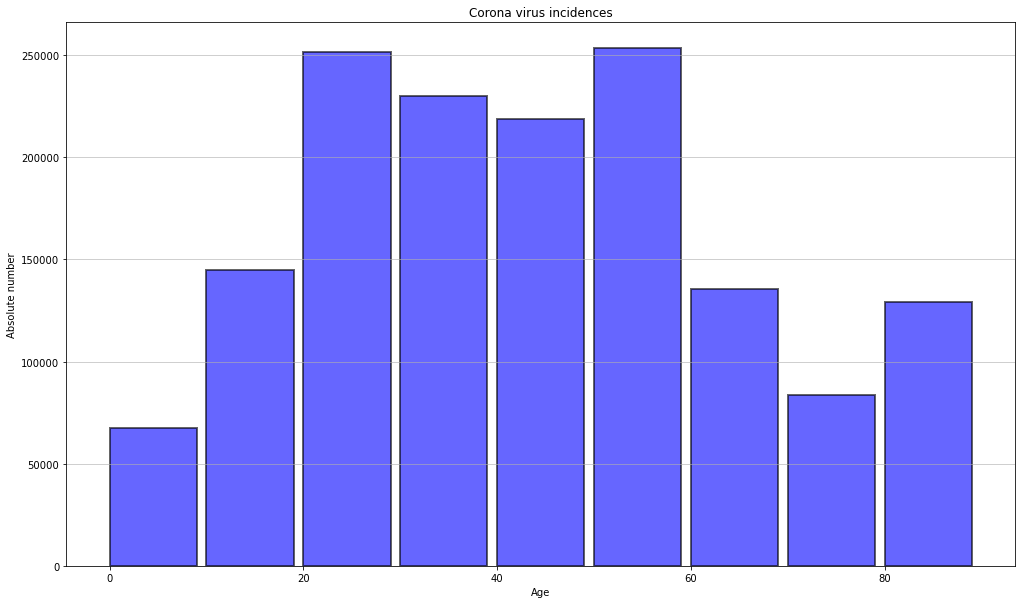

In [875]:
plt.subplots(figsize=(17, 10))
plt.grid(axis='y', alpha=0.75)
b2 = plt.bar(bins, total["incidences"], align='edge', width=9, alpha=0.6, 
        color="blue", edgecolor="black", linewidth=2)

plt.xlabel("Age")
plt.ylabel("Absolute number")
plt.title("Corona virus incidences")
plt.show()

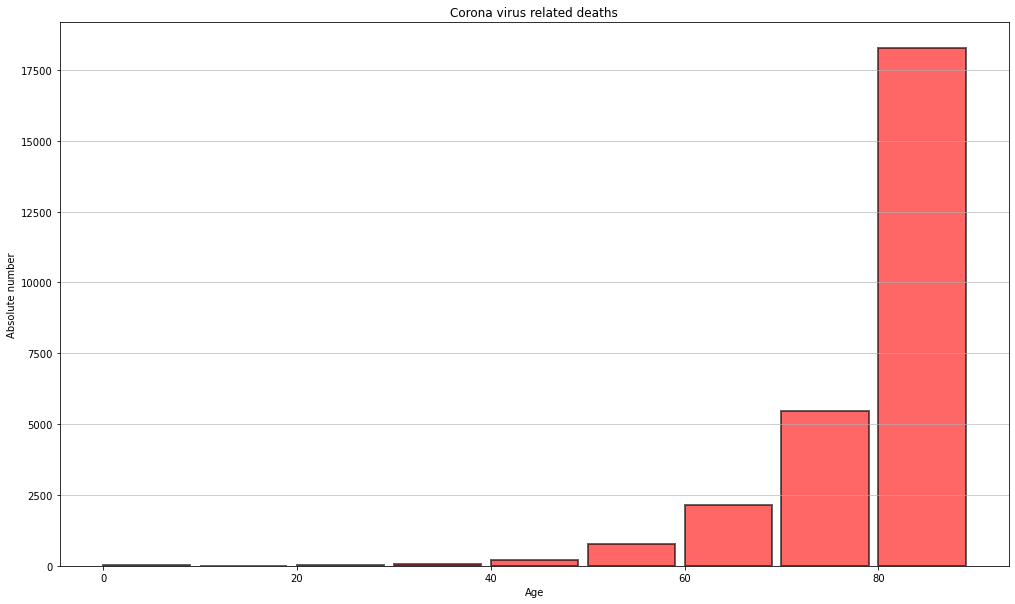

In [876]:
plt.subplots(figsize=(17, 10))
plt.grid(axis='y', alpha=0.75)
b3 = plt.bar(bins, total["deaths"], align='edge', width=9, alpha=0.6, 
        color="red", edgecolor="black", linewidth=2)
plt.xlabel("Age")
plt.ylabel("Absolute number")
plt.title("Corona virus related deaths")
plt.show()

In [863]:
# Conclusions:

# The majority of the citizens living in Germany are in the working age group (between 20 - 60/70 years), about 2/3
print("Citizens in working age: {:.2f} %".format(demography[demography.columns[2:-3]].sum(axis=1)[0]/demography[demography.columns[:-1]].sum(axis=1)[0]))

# Only single digit percentage has already been tested for the Corona virus
print("Percentage tested: {:.2f} %".format(incidences[incidences.columns[:-1]].sum(axis=1)[0] / demography[demography.columns[:-1]].sum(axis=1)[0]))

# The distribution of Corona related deaths is highly skewed, the number of
# deaths seems to correlate with the age of the patients

Citizens in working age: 0.66 %
Percentage tested: 0.02 %


In [880]:
# Let us study the percentages, to get a better understanding of the data
# The barplots below serve only for illustrative purpose

scatter_bins = [bin+4.5 for bin in bins]

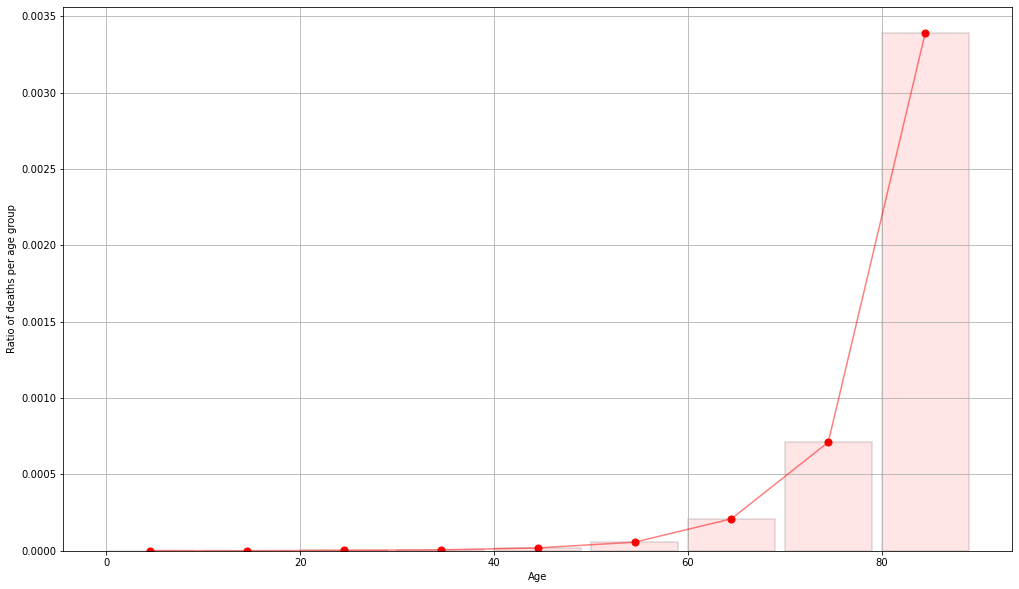

In [882]:
plt.subplots(figsize=(17, 10))
plt.grid()
plt.bar(bins, total["ratio_dd"], color="red", alpha=.1,
        align='edge', width=9, edgecolor="black", linewidth=2)
plt.plot(scatter_bins, total["ratio_dd"], color="red", alpha=.5)
plt.scatter(scatter_bins, total["ratio_dd"], color="red", s=50)

plt.xlabel("Age")
plt.ylabel("Ratio of deaths per age group")
#plt.title("")
plt.show()

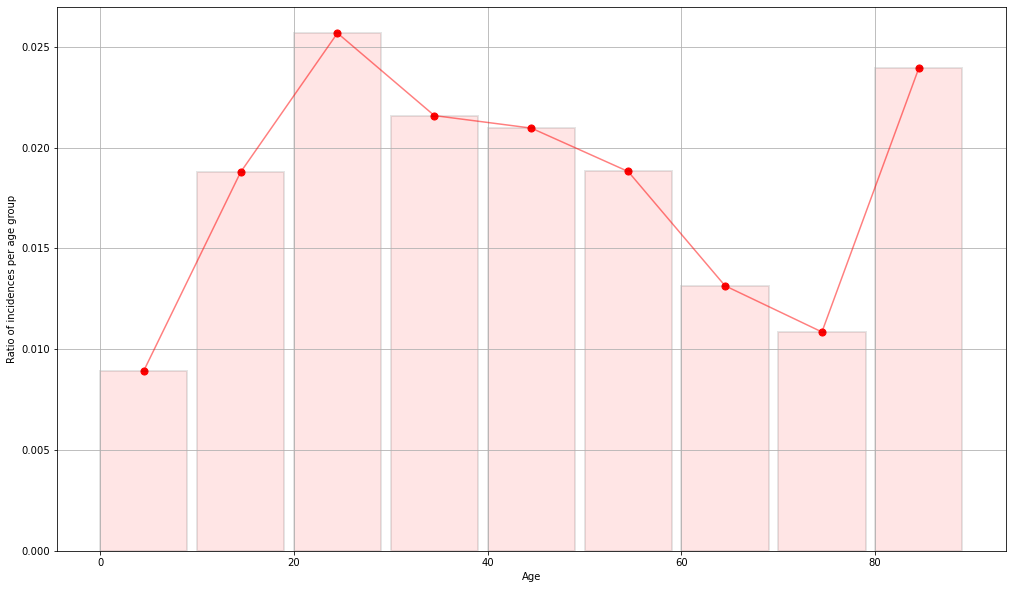

In [883]:
plt.subplots(figsize=(17, 10))
plt.grid()
plt.bar(bins, total["ratio_id"], color="red", alpha=.1,
        align='edge', width=9, edgecolor="black", linewidth=2)
plt.plot(scatter_bins, total["ratio_id"], color="red", alpha=.5)
plt.scatter(scatter_bins, total["ratio_id"], color="red", s=50)

plt.xlabel("Age")
plt.ylabel("Ratio of incidences per age group")
#plt.title("")
plt.show()

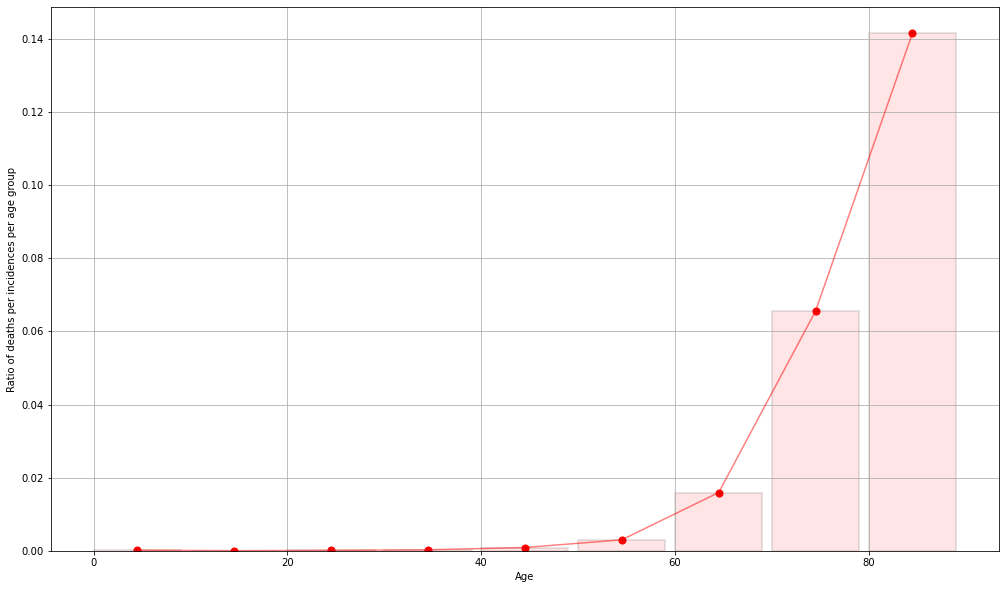

In [884]:
plt.subplots(figsize=(17, 10))
plt.grid()
plt.bar(bins, total["ratio_di"], color="red", alpha=.1, 
        align='edge', width=9,  edgecolor="black", linewidth=2)
plt.plot(scatter_bins, total["ratio_di"], color="red", alpha=.5)
plt.scatter(scatter_bins, total["ratio_di"], color="red", s=50)

plt.xlabel("Age")
plt.ylabel("Ratio of deaths per incidences per age group")
#plt.title("")
plt.show()

In [885]:
# Conclusions:

# The probability of a Corona related death increase with the age of the patient
# Incidences tend to happen (or be found) more often for younger generations, except 
# for the group of the oldest patients (steep increase). This might be caused by data consolidation (grouping of multiple 
# age group into one) or the lower uncertainty for unreported Corona cases (Dunkelziffer)

# Fit the curves

Exponential fit:  [ 1.48184047e-03  2.83665966e+01  1.12559524e+01 -2.17505726e-03]
Polynomial fit:  [4.62767590e+01 4.92651809e-03 1.90184726e-03 4.57423823e-05]


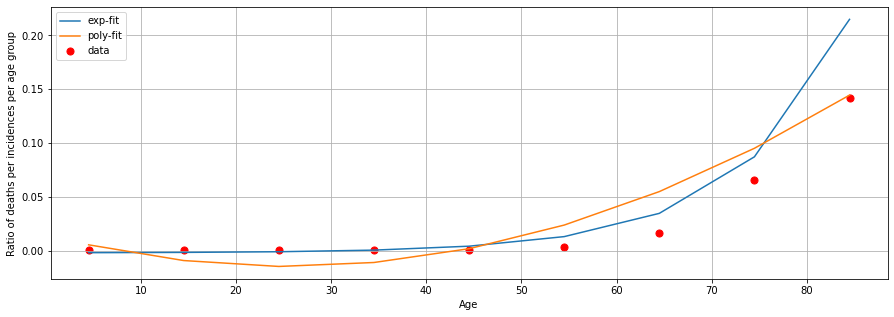

In [887]:
from scipy.optimize import curve_fit

def exp_func(x, n0, x0, rate, bias):
    return n0 * np.exp((x-x0)/rate) + bias

def poly_func(x, x0, a0, a1, a2):
    return a0 + a1*(x-x0) + a2*(x-x0)**2

exp_popt, exp_pcov = curve_fit(exp_func, bins, total["ratio_di"], p0=(0.01, 1, 50, 0))
print("Exponential fit: ", exp_popt)

poly_popt, poly_pcov = curve_fit(poly_func, bins, total["ratio_di"], p0=(1, 0.01, 0.0001, 0.0001))
print("Polynomial fit: ", poly_popt)

plt.figure(figsize=(15, 5))
plt.grid()
y = exp_func(scatter_bins, *exp_popt)
plt.plot(scatter_bins, y, label="exp-fit")
y = poly_func(scatter_bins, *poly_popt)
plt.plot(scatter_bins, y, label="poly-fit")
plt.scatter(scatter_bins, total["ratio_di"], color="red", s=50, label="data")
plt.legend()
plt.xlabel("Age")
plt.ylabel("Ratio of deaths per incidences per age group")
#plt.title("")
plt.show()

# Both models are underfitting the data
# TODO: Try OLS if uncertainty estimates are available

# Estimate mortality rate

In [ ]:
# We try to reproduce mortality rates for two scenarios:

# 1. We base our estimates on the data excerpts available by 27.12.2020
# This will likely yield a lower mortality rate, because the incidences incorporated contain incomplete Corona virus cases
# (e.g., freshly infected persons have not undergone complications including death)

# 2. We exclude incidence rates of the latest 14 days

# Our computations are the same for both scenarios, including

# Scenario 1.

In [907]:
# TODO: Apply it

# Question: Can we estimate the uncertainty on the mortality rates?
# - Yes, we can try error propagation.
# We can apply a set of different models for the uncertainty calculation
# 1. Constant value for each group
# 2. Linear model
# 3. Unreported rate is weighted proportional to age group counts per bin
# 4. Unreported rate is weighted inversely to age group counts per bin

def calc_uncertainty(deaths, incidences, delta_deaths, delta_incidences):
    return np.sqrt( (delta_deaths / incidences)**2 + (deaths * delta_incidences / incidences**2 )**2 )

ratio_di_uncertainties = []
for _, row in total.iterrows():
    ratio_di_uncertainties.append(calc_uncertainty(row["deaths"], row["incidences"], 
                                                   0.1*row["deaths"], 0.01*row["incidences"]))
#total["ratio_di_uncertainties"] = ratio_di_uncertainties

#sum(total["ratio_di"] / total["ratio_di_uncertainties"]**2) / sum(1/total["ratio_di_uncertainties"]**2)

In [892]:
print("Mean mortality rate: {:.3f} +- {:.3f}".format(total["ratio_di"].mean(), total["ratio_di"].std()))

Mean mortality rate: 0.025 +- 0.049


In [902]:
# Weight mortality rate by demography

mort_weight = sum(total["age"]*total["ratio_di"])/total["age"].sum()
std_term1 = sum(total["age"]*total["ratio_di"]**2)/total["age"].sum()
std_weight = np.sqrt(std_term1 - mort_weight**2) 
print("Mean weighted mortality rate: {:.3f} +- {:.3f}".format(mort_weight, std_weight))

# Worst case scenario: every German citizen gets infected
print("Expected death toll: {:d}".format(int(mort_weight * demography[demography.columns[:-1]].sum(axis=1)[0])))

Mean weighted mortality rate: 0.018 +- 0.038
Expected death toll: 1486614


In [900]:
# We study, how the rate of unreported cases affects the mortality rate
# The reported deaths are considered highly reliable

unreported_rate = 4 # between 4 - 6

In [901]:
# Assumption 1:
# Constant unreported rate
total["incidences_c1"] = total["incidences"]*unreported_rate

# Asssumption 2:
# Unreported rate decreases linearly (or via low polynomial) with age groups
# lowest group 4, highest group 1 (or 0)
tmp = np.linspace(unreported_rate, 1, 9)
tmp = tmp*unreported_rate*9/tmp.sum()
total["incidences_c2"] = total["incidences"]*x

# Assumption 3:
# Unreported rate is weighted proportional to demographic bin weight
total["incidences_c3"] = total["incidences"]*(total["incidences"]/total["incidences"].sum())*unreported_rate*9

# Assumption 4:
# Unreported rate is weighted inversely proportional to demographic bin weight
tmp = ((1/total["incidences"])/(1/total["incidences"]).sum()).values*unreported_rate*9
total["incidences_c4"] = total["incidences"]*tmp

# Check if boundary conditions are met (i.e., are incidences <= number of citizens in a demographic bin)
for i in range(1, 5):
    total[f"incidences_c{i}"].where(total[f"incidences_c{i}"]<=total["age"], total["age"], inplace=True)
    total[f"ratio_di_c{i}"] = total["deaths"] / total[f"incidences_c{i}"]

total

,age,deaths,incidences,ratio_dd,ratio_id,ratio_di,incidences_c1,incidences_c2,incidences_c3,incidences_c4,ratio_di_c1,ratio_di_c2,ratio_di_c3,ratio_di_c4
0-9,7589000.0,12.0,67685.0,1.581236e-06,0.008919,0.000177,270740.0,433184.0,1.089480e+05,548343.4375,0.000044,0.000028,0.000110,0.000022
10-19,7706000.0,5.0,144684.0,6.488451e-07,0.018776,0.000035,578736.0,839167.2,4.978238e+05,548343.4375,0.000009,0.000006,0.000010,0.000009
20-29,9801000.0,28.0,251667.0,2.856851e-06,0.025678,0.000111,1006668.0,1308668.4,1.506216e+06,548343.3750,0.000028,0.000021,0.000019,0.000051
30-39,10646000.0,64.0,229802.0,6.011648e-06,0.021586,0.000279,919208.0,1057089.2,1.255863e+06,548343.4375,0.000070,0.000061,0.000051,0.000117
40-49,10426000.0,197.0,218590.0,1.889507e-05,0.020966,0.000901,874360.0,874360.0,1.136306e+06,548343.4375,0.000225,0.000225,0.000173,0.000359
50-59,13474000.0,761.0,253490.0,5.647914e-05,0.018813,0.003002,1013960.0,861866.0,1.528116e+06,548343.3750,0.000751,0.000883,0.000498,0.001388
60-69,10302000.0,2157.0,135417.0,2.093768e-04,0.013145,0.015929,541668.0,379167.6,4.360949e+05,548343.4375,0.003982,0.005689,0.004946,0.003934
70-79,7686000.0,5468.0,83419.0,7.114233e-04,0.010853,0.065549,333676.0,183521.8,1.654872e+05,548343.4375,0.016387,0.029795,0.033042,0.009972
80+,5390000.0,18272.0,129044.0,3.389981e-03,0.023941,0.141595,516176.0,206470.4,3.960137e+05,548343.4375,0.035399,0.088497,0.046140,0.033322


In [899]:
# TODO: Compare with generic mortality rates for age groups

for i in range(1, 5):
    col = f"ratio_di_c{i}"
    mort_weight = sum(total["age"]*total[col])/total["age"].sum()
    std_term1 = sum(total["age"]*total[col]**2)/total["age"].sum()
    std_weight = np.sqrt(std_term1 - mort_weight**2)
    print("Mean weighted mortality rate: {:.3f} +- {:.3f}".format(mort_weight, std_weight))
    
# The inclusion of unreported Corona virus infections in our calculations decreases the mortality rate mutually towards a
# subpercentage value (<1%), at least by a factor of 2

Mean weighted mortality rate: 0.004 +- 0.009
Mean weighted mortality rate: 0.009 +- 0.023
Mean weighted mortality rate: 0.007 +- 0.014
Mean weighted mortality rate: 0.004 +- 0.008


# Scenario 2.

In [909]:
# Follows

# Unspecified from here

In [936]:
data = pd.read_excel("klinischeAspekete.xlsx", sheet_name=1)
data.index = data["KW"]
data.drop(["KW"], axis=1, inplace=True)
data.tail()

,Fälle gesamt,Mittelwert Alter (Jahre),Männer,Frauen,Anzahl mit Angaben zu Symptomen,"Anteil keine, bzw. keine für COVID-19 bedeutsamen Symptome",Anzahl mit Angaben zur Hospitalisierung,Anzahl hospitalisiert,Anteil hospitalisiert,Anzahl Verstorben,Anteil Verstorben
KW,,,,,,,,,,,
48,123357,44,0.465685,0.534315,70830,0.154059,80434,7181,0.089278,2728,0.022115
49,128304,45,0.459605,0.540395,73303,0.143855,82678,7620,0.092165,2956,0.023039
50,155956,46,0.453751,0.546249,86334,0.148945,97363,8883,0.091236,3064,0.019647
51,173481,46,0.452257,0.547743,89081,0.147888,101764,8899,0.087447,2118,0.012209
52,135974,48,0.445641,0.554359,56966,0.162009,71416,5983,0.083777,732,0.005383


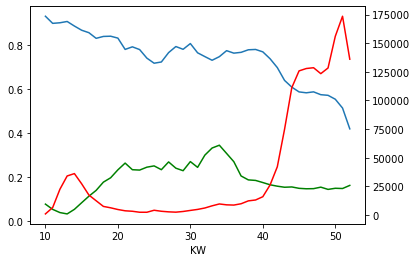

In [942]:
# Why is the detail of data collected / data forwarded continuously decreasing, even during low incidences in summer?

(data["Anzahl mit Angaben zu Symptomen"]/data["Fälle gesamt"]).plot()
data["Fälle gesamt"].plot(secondary_y=True, style="r")
data["Anteil keine, bzw. keine für COVID-19 bedeutsamen Symptome"].plot(style="g")

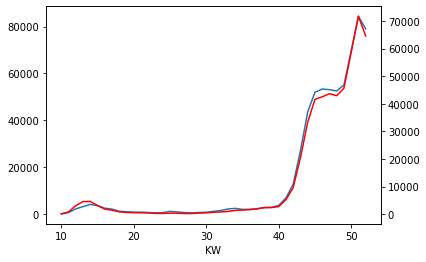

In [954]:
(data["Fälle gesamt"]-data["Anzahl mit Angaben zu Symptomen"]).plot()
(data["Fälle gesamt"]-data["Anzahl mit Angaben zur Hospitalisierung"]).plot(secondary_y=True, style="r")

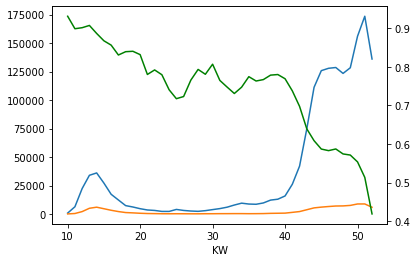

In [950]:
data["Fälle gesamt"].plot()
data["Anzahl hospitalisiert"].plot()
(data["Anzahl mit Angaben zu Symptomen"]/data["Fälle gesamt"]).plot(secondary_y=True, style="g")

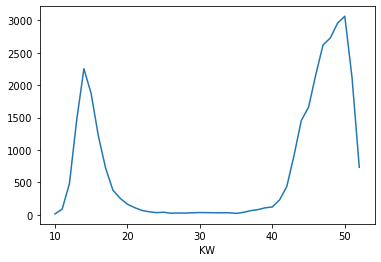

In [953]:
data["Anzahl Verstorben"].plot()

# Intensive care data

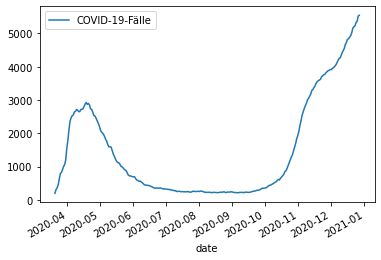

In [914]:
# only a very rough approximation of the number of intensive care patients
# better: sum on deltas (incoming, leaving intensive care patients)

intensivecare = pd.read_csv("intensivbehandelt.csv")
intensivecare["date"] = intensivecare["date"].apply(lambda x: x.split('+')[0])
intensivecare["date"] = pd.to_datetime(intensivecare["date"], format="%Y-%m-%d %H:%M:%S")
intensivecare.index = intensivecare.date
intensivecare.drop("date", axis=1, inplace=True)
intensivecare.plot()

# Retrieve intensive care data

In [336]:
# How to do it:
# 1. Run download_daily_intensivcare_reports()
# 2. Loop through the individual reports with get_statistics_from_report()

def download_daily_intensivcare_reports(pages=(1,4)):
    """Define search pages to parse."""
    # TODO: Add check, if maximum page limit is exceeded (check for "Die Suche ergab keine Treffer" in r.content)
    df = []
    for page in range(*pages):
        r = requests.get(f"https://edoc.rki.de/handle/176904/7011/discover?rpp=100&etal=0&query=tagesreport&scope=&group_by=none&page={page}&sort_by=score&order=desc")
        content = BeautifulSoup(r.content)
        results = content.find_all("div", attrs={"class": "ds-artifact-list"})
        dfs = []
        for result in results:
            href_ext = result.find_all("a")[0]["href"].split("/")[-1]
            title = result.find_all("div", attrs={"class": "artifact-title"})[0].get_text().split("\n")[0]
            date = result.find_all("div", attrs={"class": "artifact-subtitle"})[0].get_text()

            if "Tagesreport aus dem DIVI-Intensivregister" in title:
                dfs.append((date, href_ext, title))
        dfs = pd.DataFrame(dfs)
        dfs.columns = ["report_date", "href_ext", "report_title"]
        df.append(dfs)
    df = pd.concat(df, ignore_index=True).reset_index(drop=True)
    df.to_csv("corona_links.csv", index=False)
    
def get_statistics_from_report(url, date):
    """Extracts the summary table from the daily reports"""
    r = requests.get(url)
    report = url.split("/")[-1].split("?")[0]
    with open(f"./report_downloads/{date}", "wb") as f:
        f.write(r.content)

    pages = convert_from_path('./report_downloads/{}'.format(date),
                              500)
    imagename = report.split(".")[0]
    filename = './report_downloads/{}.jpg'.format(imagename)
    for _, page in enumerate(pages):
        page.save(filename, 'JPEG')

    TESS_CONFIG = r"--psm 6 --dpi 320 --tessdata-dir 'C:/Program Files/Tesseract-OCR/tessdata/' -l deu"
    text = image_to_string(Image.open(filename), lang='deu', 
                                         config=TESS_CONFIG)
      
    summary = text.split("Fallzahlen COVID")[1].split('\n')[1:7]
    summary_clean = [re.sub(r"\([\d\%]+\)", "", part.replace(".", "")) for part in summary]

    titles = pd.DataFrame([re.split(r"\d+", part) for part in summary_clean])
    values = pd.DataFrame([re.split(r"\D+", part) for part in summary_clean])
    values[0] = titles[0]
    values = values.loc[1:, [0,1,2]]
    values["date"] = date
    values.columns = ["description", "current_values", "delta_values", "date"]
    values.to_csv('./output/{}.csv'.format(date), index=False)

In [337]:
hrefs = pd.read_csv("corona_links.csv").sort_values("report_date", ascending=False)
hrefs.head()

,report_date,href_ext,report_title
55,2020-12-27,7603,Tagesreport aus dem DIVI-Intensivregister
138,2020-12-26,7601,Tagesreport aus dem DIVI-Intensivregister
137,2020-12-25,7599,Tagesreport aus dem DIVI-Intensivregister
136,2020-12-24,7597,Tagesreport aus dem DIVI-Intensivregister
135,2020-12-23,7595,Tagesreport aus dem DIVI-Intensivregister


In [ ]:
successes = []
failures = []
for _, row in hrefs.iterrows():
    try:
        url = "https://edoc.rki.de/bitstream/handle/176904/{}/2020-12-27_12-15_DIVI_Intensivregister_Report.pdf?sequence=1&isAllowed=y".format(row["href_ext"])
        get_statistics(url, row["report_date"])
        successes.append(_)
    except:
        failures.append(_)
print(failures)    

In [325]:
daily_reports = glob.glob("./output/*.csv")

def date_convertor(self):
    if "." in self:
        day, month, year = self.split(".")
        return f"{year}-{month}-{day}"
    else:
        return self

daily_reports_df = pd.concat([pd.read_csv(report) for report in daily_reports], ignore_index=True).reset_index(drop=True)
daily_reports_df["date"] = daily_reports_df["date"].apply(date_convertor)
daily_reports_df["date"] = pd.to_datetime(daily_reports_df["date"], format="%Y-%m-%d")
daily_reports_df.head()

,description,current_values,delta_values,date
0,Aktuell in intensivmedizinischer Behandlung,4339.0,61.0,2020-12-10
1,davon invasiv beatmet,2505.0,6.0,2020-12-10
2,Neuaufnahmen auf ITS seit Vortag,689.0,NaN,2020-12-10
3,Gesamt mit abgeschlossener Behandlung,36984.0,628.0,2020-12-10
4,davon verstorben,8873.0,168.0,2020-12-10


In [338]:
sorted(daily_reports_df["description"].unique().astype("str").tolist())

['Aktuell in intensivmedizinischer Behandlung',
 'Gesamt abgeschlossene Behandlungen',
 'Neuaufnahmen auf ITS seit Vortag',
 'davon beatmet',
 'davon verstorben',
 'gesamt abgeschlossene Behandlungen']

In [339]:
def text_cleaner(self):
    if (str(self).endswith(" IQI") or str(self).endswith(" a") or str(self).endswith(" Do, +")
        or str(self).endswith(" I")):
        return str(self).replace(" IQI", "").replace(" a", "").replace(" Do, +", "").replace(" I", "")
    else:
        return self
    
daily_reports_df["description"] = daily_reports_df["description"].str.strip().apply(text_cleaner)

In [344]:
def grouper(self):
    if self in ['Gesamt abgeschlossene Behandlungen',
         'Gesamt mit abgeschlossener Behandlung',
         'Gesamtbgeschlossene Behandlungen',
         'gesamt abgeschlossene Behandlungen']:
        return "Gesamt abgeschlossene Behandlungen"
    elif self in ['Neuaufnahmen auf ITS seit Vortag',
     'NeuaufnahmenufTS seit Vortag']:
        return "Neuaufnahmen auf ITS seit Vortag"
    elif self in ['davon beatmet',
     'davon invasiv beatmet']:
        return "davon beatmet"
    elif self in ['Aktuell in intensivmedizinischer Behandlung',
                  'aktuell in intensivmedizinischer Behandlung']:
        return "Aktuell in intensivmedizinischer Behandlung"
    elif self in ['* aktuell ist ein Vergleich zum Vortag durch die täglich veränderliche Zusammensetzung berichtender Krankenhaus-Standorte nicht sinnvoll',
 '* zu beachten die ggf veränderte Anzahl berichtender Kliniken/Abteilungen', 'nan', 'zu Stand']:
        return "DELETED"
    else:
        return self
    
daily_reports_df["description"] = daily_reports_df["description"].apply(grouper)
daily_reports_df = daily_reports_df.sort_values("date")

In [345]:
sorted(daily_reports_df["description"].unique().astype("str"))

['Aktuell in intensivmedizinischer Behandlung',
 'Gesamt abgeschlossene Behandlungen',
 'Neuaufnahmen auf ITS seit Vortag',
 'davon beatmet',
 'davon verstorben']

In [346]:
daily_reports_df = daily_reports_df.loc[~daily_reports_df["description"].isin(["DELETED", np.nan, "Anzahl Intensivbetten",  'Intensivmedizinische Behandlungskapazitäten', 'Veränderung zum Vortag']), :]

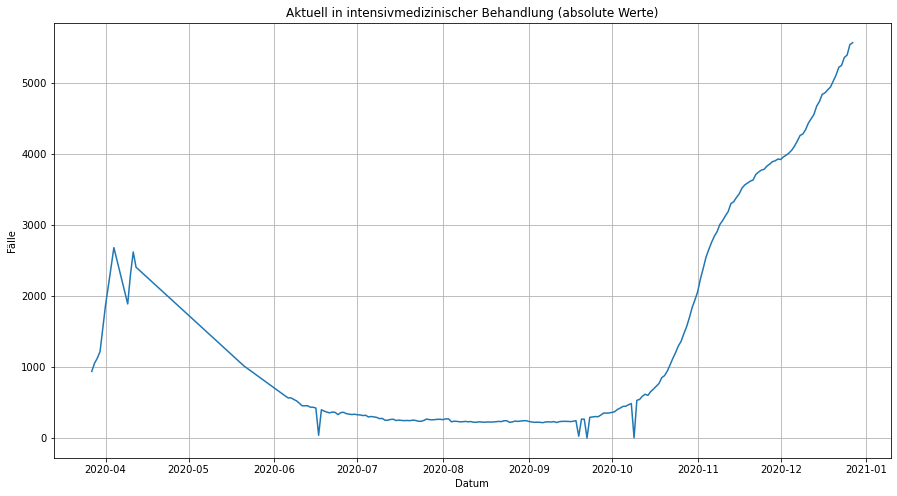

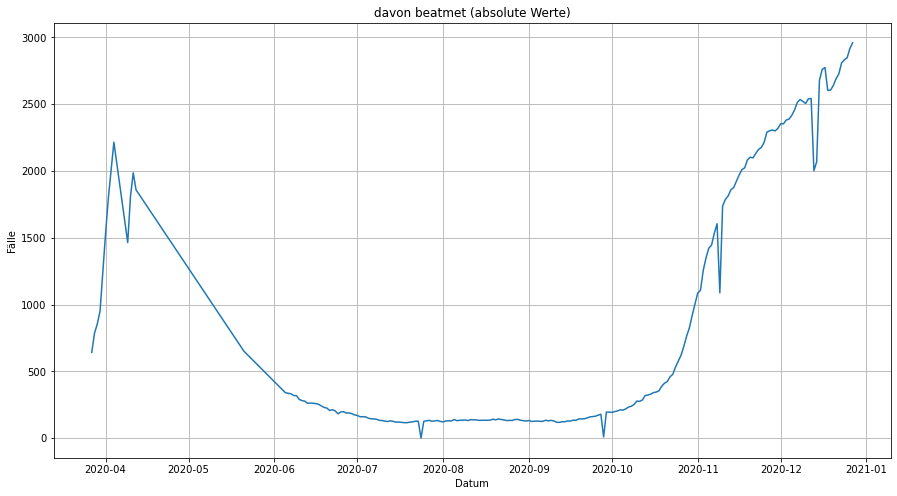

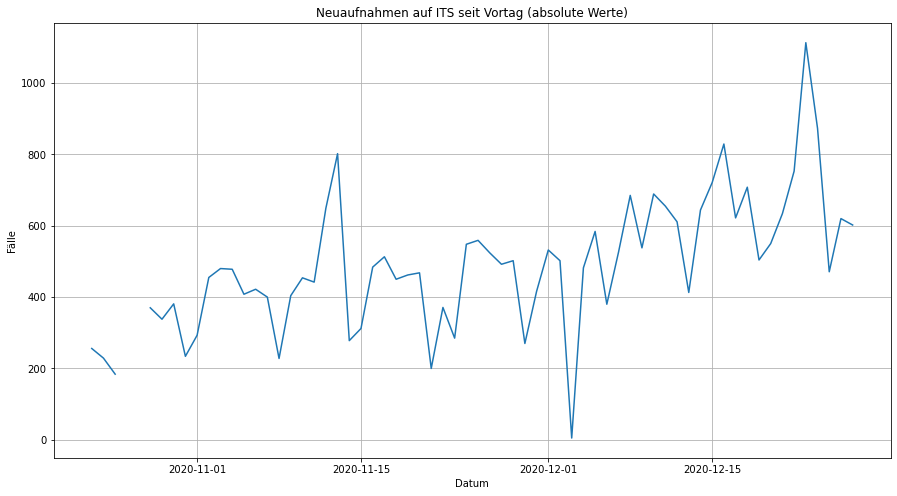

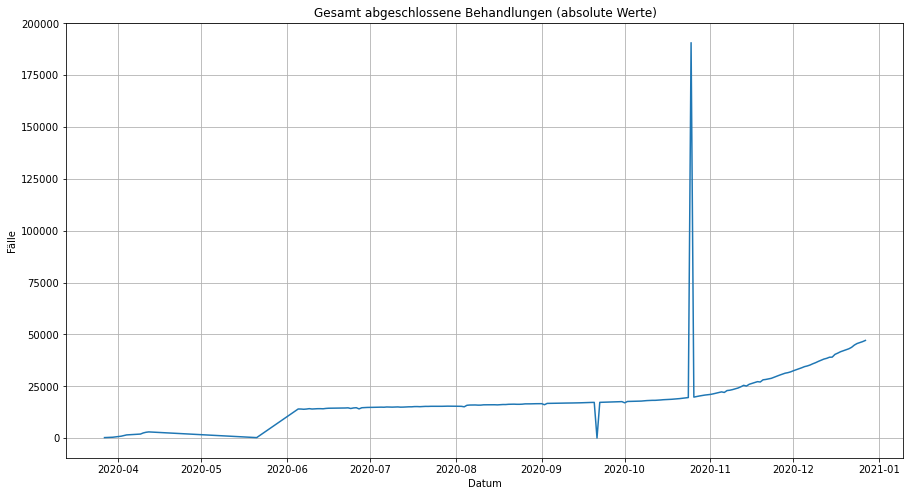

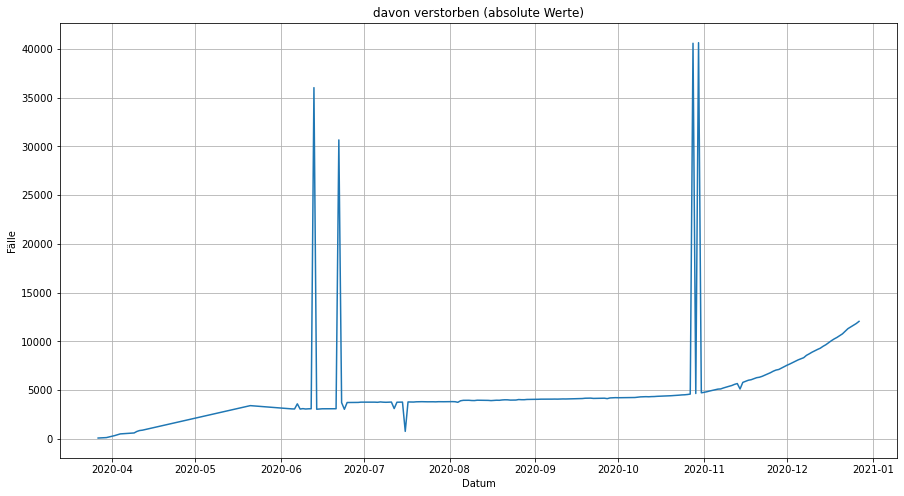

In [349]:
# TODO: Clean / verify genuity of outliers

for col in ['Aktuell in intensivmedizinischer Behandlung',
 'davon beatmet',
 'Neuaufnahmen auf ITS seit Vortag',
 'Gesamt abgeschlossene Behandlungen',
 'davon verstorben']:
    filter_ = daily_reports_df["description"] == col
    plt.figure(figsize=(15, 8))
    plt.grid()
    plt.plot(daily_reports_df["date"][filter_], daily_reports_df["current_values"][filter_])
    plt.title(col + " (absolute Werte)")
    plt.xlabel("Datum")
    plt.ylabel("Fälle")
    plt.show()

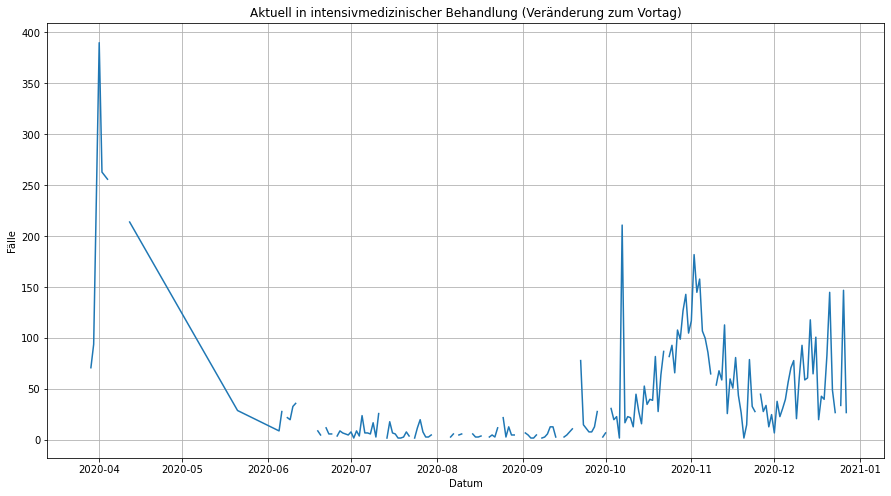

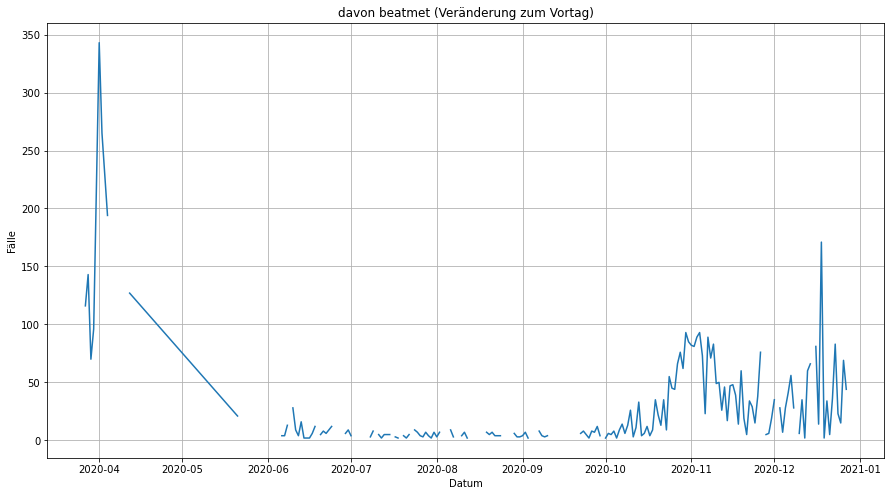

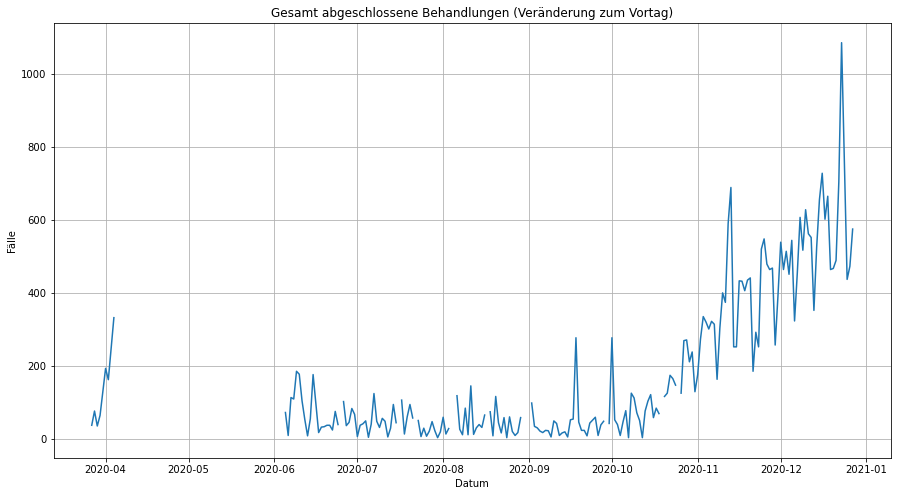

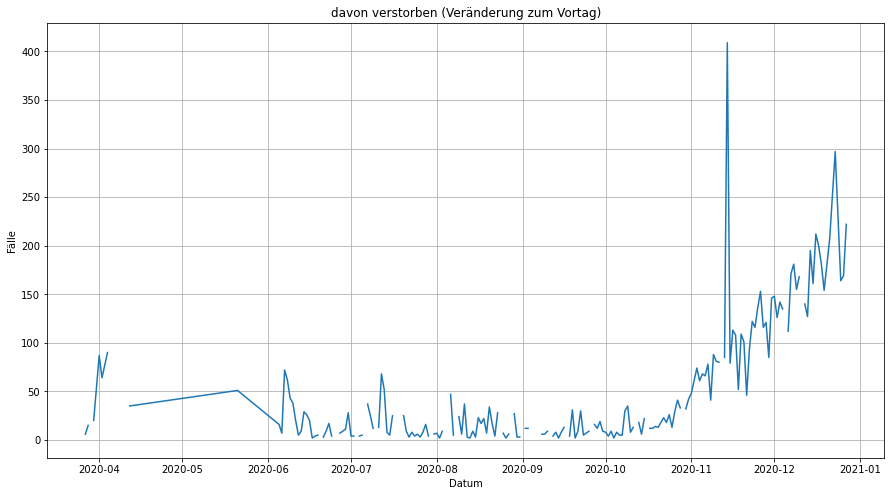

In [351]:
for col in ['Aktuell in intensivmedizinischer Behandlung',
 'davon beatmet',
 'Gesamt abgeschlossene Behandlungen',
 'davon verstorben']:
    filter_ = daily_reports_df["description"] == col
    plt.figure(figsize=(15, 8))
    plt.grid()
    plt.plot(daily_reports_df["date"][filter_], daily_reports_df["delta_values"][filter_])
    plt.title(col + " (Veränderung zum Vortag)")
    plt.xlabel("Datum")
    plt.ylabel("Fälle")
    plt.show()